# **Importing Libraries**

In [1]:
#library
import pandas as pd
import numpy as np
import random as rnd
import os
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

# Importing other tools
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

# **Data Cleaning and Preprocessing**

In [2]:
coordinate_file_path = 'Vietnam CordinateFile.xlsx'
daluong_file_path = 'VietnamDatasets.xlsx'

df_coordinate = pd.read_excel(coordinate_file_path)
df_daluong = pd.read_excel(daluong_file_path)

FileNotFoundError: [Errno 2] No such file or directory: 'Vietnam CordinateFile.xlsx'

In [ ]:
coordinate_columns = ['Well Point Number', 'Longitude and Latitude']
daluong_columns = ['well_code', 'na', 'k', 'ca2', 'mg2', 'fe3', 'fe2', 'cl', 'so4', 'hco3',
                   'co3', 'no2', 'hardness_general', 'no3', 'hardness_temporal',
                   'hardness_permanent', 'ph', 'co2_free', 'co2_depend', 'co2_infiltrate',
                   'sio2', 'tds105']

df_coordinate = df_coordinate[coordinate_columns]
df_daluong = df_daluong[daluong_columns]

### Handling Missing Values:

In [ ]:
# Check for missing values and display the report
daluong_mean_columns = ['fe2', 'fe3', 'no2', 'no3', 'co2_infiltrate', 'sio2']
for col in daluong_mean_columns:
    df_daluong[col].fillna(df_daluong[col].mean(), inplace=True)

# Drop rows with missing values show the results with indicative rows that are dropped.
df_daluong.dropna(subset=daluong_columns, inplace=True)

### Removing Duplicates:

In [ ]:
df_daluong.drop_duplicates(inplace=True)

### Data Formatting:

1.   Standardize data formats across the dataset, such as date formats, numeric formats, and text formats.
2.   Convert categorical variables to a consistent format (e.g., lowercase, title case) using string manipulation functions.



In [ ]:
df_coordinate[['Longitude', 'Latitude']] = df_coordinate['Longitude and Latitude'].str.split(',', expand=True)
df_coordinate.drop('Longitude and Latitude', axis=1, inplace=True)
df_coordinate.rename({'Well Point Number': 'well_code'}, axis=1, inplace=True)

### Handling Outliers:

1.   Identify outliers in numerical data using statistical methods like z-score, IQR (Interquartile Range), or visualization techniques like box plots.
2.   Decide on a strategy to handle outliers, such as capping, winsorization, or removal.



In [ ]:
def remove_outliers_iqr(dataframe, column):
    '''
    Remove outliers using the IQR method
    :param dataframe:
    :param column:
    :return:
    '''
    Q1 = dataframe[column].quantile(0.05)
    Q3 = dataframe[column].quantile(0.95)
    IQR = Q3 - Q1
    df = dataframe[~((dataframe[column] < (Q1 - 1.5 * IQR)) | (dataframe[column] > (Q3 + 1.5 * IQR)))]
    return df


df_daluong = remove_outliers_iqr(df_daluong, 'cl')

### Correcting Inconsistent Data:

1.   Identify and correct inconsistencies in the data, such as misspellings, inconsistent naming conventions, or conflicting information.
2.   Use string manipulation functions or regular expressions to correct inconsistencies in textual data.



In [ ]:
df_daluong_tmp = df_daluong.copy(deep=True)
def binarize(column, threshold):
    '''
    Binarize the column based on the threshold
    :param column:
    :param threshold:
    :return:
    '''
    return column.apply(lambda x: 1 if x <= threshold else 0)


def binarize_inclusive(column, lower_bound, upper_bound):
    '''
    Binarize the column based on the lower and upper bounds
    :param column:
    :param lower_bound:
    :param upper_bound:
    :return:
    '''
    return column.apply(lambda x: 1 if (x >= lower_bound and x <= upper_bound) else 0)

df_daluong_tmp['ph'] = binarize_inclusive(df_daluong_tmp['ph'], 5.5, 8.5)
df_daluong_tmp['fe2'] = binarize(df_daluong_tmp['fe2'], 5)
df_daluong_tmp['fe3'] = binarize(df_daluong_tmp['fe3'], 5)
df_daluong_tmp['cl'] = binarize(df_daluong_tmp['cl'], 250)
df_daluong_tmp['so4'] = binarize(df_daluong_tmp['so4'], 400)
df_daluong_tmp['tds105'] = binarize(df_daluong_tmp['tds105'], 400)
df_daluong_tmp['hardness_general'] = binarize(df_daluong_tmp['hardness_general'], 500)
df_daluong_tmp['na'] = binarize(df_daluong_tmp['na'], 200)
df_daluong_tmp['k'] = binarize(df_daluong_tmp['k'], 12)
df_daluong_tmp['mg2'] = binarize(df_daluong_tmp['mg2'], 50)
df_daluong_tmp['ca2'] = binarize(df_daluong_tmp['ca2'], 75)
df_daluong_tmp['no3'] = binarize(df_daluong_tmp['no3'], 15)
df_daluong_tmp['no2'] = binarize(df_daluong_tmp['no2'], 1)
df_daluong_tmp['hco3'] = binarize(df_daluong_tmp['hco3'], 350)
df_daluong_tmp['co3'] = binarize(df_daluong_tmp['co3'], 1)
df_daluong_tmp['hardness_temporal'] = 1
df_daluong_tmp['hardness_permanent'] = 1
df_daluong_tmp['co2_free'] = 1
df_daluong_tmp['co2_depend'] = 1
df_daluong_tmp['co2_infiltrate'] = 1
df_daluong_tmp['sio2'] = 1

df_daluong['is_drinkable'] = df_daluong_tmp.drop('well_code', axis=1).apply(lambda row: int(row.nunique() == 1), axis=1)

### Data Transformation:

1.   Transform data to a suitable scale or distribution, such as logarithmic transformation for skewed data.
2.   Perform feature scaling or normalization to ensure that variables are on a similar scale.



In [ ]:
values = [200, 12, 75, 50, 5, 5, 250, 400, 350, 1, 1, 15, 8.5, 400, 500, 242, 393, 51, 127, 16, 5]
wi = [((1 / sum(values)) / value) for value in values]


def calculate_norm(dataframe, column, scale):
    if column == 'ph':
        return [100 * ((i - scale) / (8.5 - scale)) for i in dataframe[column]]
    else:
        return [100 * (i / scale) for i in dataframe[column]]


norm_values = dict()  # Empty dictionary to hold all the norm values

columns = ['ph', 'fe2', 'fe3', 'so4', 'tds105', 'hardness_general', 'no2', 'no3', 'ca2', 'mg2', 'co2_free',
           'co2_depend', 'co2_infiltrate', 'sio2', 'na', 'k', 'hco3', 'co3', 'cl', 'hardness_temporal',
           'hardness_permanent']

scales = [7, 5, 5, 400, 400, 500, 1, 15, 75, 50, 51, 127, 16, 42, 200, 12, 350, 1, 250, 242, 393]

for column, scale in zip(columns, scales):
    norm_values[column] = calculate_norm(df_daluong, column, scale)

df_daluong['wqi'] = 0
for i in range(len(df_daluong)):
    df_daluong['wqi'].iloc[i] = sum(norm_values[column][i] * weight for column, weight in zip(columns, wi)) / sum(wi)
# Scaling the wqi values between 0 and 100
df_daluong['wqi'] = (df_daluong['wqi'] - df_daluong['wqi'].min()) / (df_daluong['wqi'].max() - df_daluong['wqi'].min()) * 100

### Handling Encoding Issues:

1.   Use appropriate encoding techniques to ensure that textual data is encoded correctly (e.g., UTF-8).
2.   Handle encoding issues that may arise due to different character encodings in the data.



In [ ]:
# Quantile to classify the water quality
quantiles = df_daluong['wqi'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]).values

# Function to classify based on dynamic quantile ranges
def water_quality_class_quantile(x):
    if x <= quantiles[1]:
        return "Poor"
    elif quantiles[1] < x <= quantiles[2]:
        return "Fair"
    elif quantiles[2] < x <= quantiles[3]:
        return "Medium"
    elif quantiles[3] < x <= quantiles[4]:
        return "Good"
    elif quantiles[4] < x:
        return "Excellent"

df_daluong['wqc'] = df_daluong['wqi'].apply(water_quality_class_quantile)

### Dealing with Irrelevant Data

1.   Identify and remove irrelevant or redundant columns or rows from the dataset.
2.   Ensure that only relevant data for the analysis is retained.



In [ ]:
features_df = df_daluong[['well_code', 'na', 'hco3', 'hardness_permanent', 'co2_free', 'sio2', 'wqc']]
df_final = pd.merge(features_df, df_coordinate, on='well_code', how='inner')

df_final['Longitude'] = df_final['Longitude'].astype('float')
df_final['Latitude'] = df_final['Latitude'].astype('float')

df_final.dropna(inplace=True)

### Data Validation:

1.   Validate data against predefined rules or constraints to ensure data integrity and consistency.
2.  Implement data validation checks to identify and flag data that does not meet specified criteria.



<Axes: >

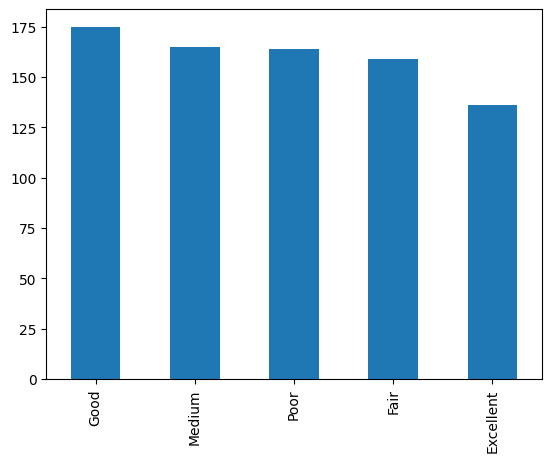

In [ ]:
df_final['wqc'].value_counts().plot(kind='bar')

# **Data Encode**

In [ ]:
# Encode the target variable
from sklearn.preprocessing import LabelEncoder

label_encoder_well_code = LabelEncoder()
df_final['well_code'] = label_encoder_well_code.fit_transform(df_final['well_code'])

X_features = df_final.drop(['wqc', 'Longitude', 'Latitude'], axis=1)
X_coordinates = df_final[['Longitude', 'Latitude']]
y_target = df_final['wqc']

from keras.utils import to_categorical

label_encoder = LabelEncoder()
y_target = label_encoder.fit_transform(y_target)
y_target = to_categorical(y_target)

label_cls = label_encoder.classes_

# **Data Split**

In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_features, X_test_features, X_train_coordinates, X_test_coordinates, y_train, y_test = train_test_split(X_features, X_coordinates, y_target, test_size=0.1, random_state=0, stratify=y_target)

# **Data Normalization**

In [ ]:
# Normalize the features
from sklearn.preprocessing import MinMaxScaler

scaler_feature = MinMaxScaler()
X_train_features = scaler_feature.fit_transform(X_train_features)
X_test_features = scaler_feature.transform(X_test_features)

scaler_coordinate = MinMaxScaler()
X_train_coordinates = scaler_coordinate.fit_transform(X_train_coordinates)
X_test_coordinates = scaler_coordinate.transform(X_test_coordinates)

X_train = [X_train_features, X_train_coordinates]
X_test = [X_test_features, X_test_coordinates]


# **Models Input Layer**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

input_features = Input(shape=(6,), name='input_features') # 6 features
input_coordinates = Input(shape=(2,), name='input_coordinates') # 2 coordinates

# **Spatial Harversine Distance Calculation**

In [ ]:
class HaversineLayer(layers.Layer):
    def call(self, inputs):
        lat, lon = inputs[..., 0], inputs[..., 1]
        return tf.expand_dims(tf.sqrt(lat ** 2 + lon ** 2), -1)

# **Embedding layer of Spatial Features E**

In [ ]:
haversine_layer = HaversineLayer()(input_coordinates)
combined_features = layers.Concatenate()([input_features, haversine_layer])

# **Reshape**

In [ ]:
reshaped_features_for_attention = layers.Reshape((1, combined_features.shape[1]))(combined_features)

# **Attention-based Network for modality Fussion (Multi-Head Attention)**

In [ ]:
multi_head_attention = layers.MultiHeadAttention(num_heads=2, key_dim=2)(reshaped_features_for_attention, reshaped_features_for_attention)
flattened_attention = layers.Flatten()(multi_head_attention)

# **Concatenation**

In [ ]:
concat_features = layers.Concatenate()([flattened_attention, combined_features])

# **Spatial 1D Convolution**

In [ ]:
concat_features = tf.expand_dims(concat_features, axis=-1)
space_conv = layers.Conv1D(64, 3, activation='LeakyReLU')(concat_features)

# **Spatial 1D Pooling**

In [ ]:
pooled = layers.GlobalMaxPooling1D()(space_conv)

# **Fully Connected Layer (Dense Layer)**

In [ ]:
dense_layer = layers.Dense(128, activation='LeakyReLU')(pooled)
dense_layer = layers.Dense(64, activation='LeakyReLU')(dense_layer)

# **OutPut - Results and Analysis**

In [ ]:
output = layers.Dense(y_train.shape[1], activation='softmax')(dense_layer)

# **Model Compilation**

In [ ]:
model = models.Model(inputs=[input_features, input_coordinates], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# **Model Training**

In [ ]:
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.15, verbose=1, shuffle=True)

Epoch 1/300
20/20 [==============================] - 3s 25ms/step - loss: 1.6077 - accuracy: 0.2406 - val_loss: 1.6059 - val_accuracy: 0.2500
Epoch 2/300
20/20 [==============================] - 0s 9ms/step - loss: 1.6052 - accuracy: 0.2324 - val_loss: 1.6042 - val_accuracy: 0.1944
Epoch 3/300
20/20 [==============================] - 0s 7ms/step - loss: 1.6027 - accuracy: 0.2520 - val_loss: 1.6028 - val_accuracy: 0.2315
Epoch 4/300
20/20 [==============================] - 0s 7ms/step - loss: 1.6001 - accuracy: 0.2766 - val_loss: 1.6005 - val_accuracy: 0.2500
Epoch 5/300
20/20 [==============================] - 0s 6ms/step - loss: 1.5974 - accuracy: 0.2700 - val_loss: 1.5989 - val_accuracy: 0.2500
Epoch 6/300
20/20 [==============================] - 0s 7ms/step - loss: 1.5944 - accuracy: 0.2750 - val_loss: 1.5970 - val_accuracy: 0.2500
Epoch 7/300
20/20 [==============================] - 0s 6ms/step - loss: 1.5915 - accuracy: 0.2684 - val_loss: 1.5952 - val_accuracy: 0.2500
Epoch 8/300


# **Model Evaluation**

Text(0.5, 1.0, 'Model Accuracy')

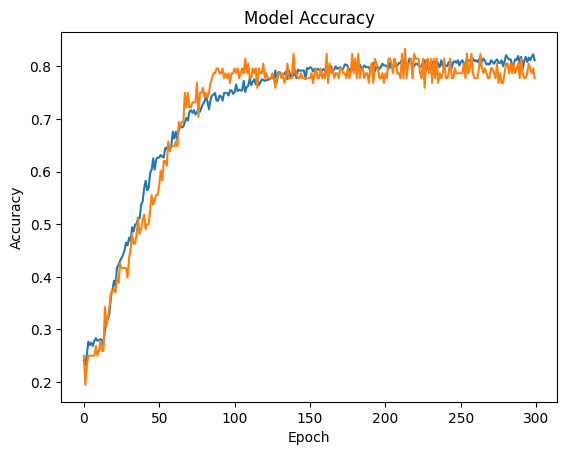

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

3/3 [==============================] - 0s 6ms/step - loss: 0.4973 - accuracy: 0.7625
Accuracy: 76.25%


In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

3/3 [==============================] - 0s 11ms/step


[Text(0, 0.5, 'Excellent'),
 Text(0, 1.5, 'Fair'),
 Text(0, 2.5, 'Good'),
 Text(0, 3.5, 'Medium'),
 Text(0, 4.5, 'Poor')]

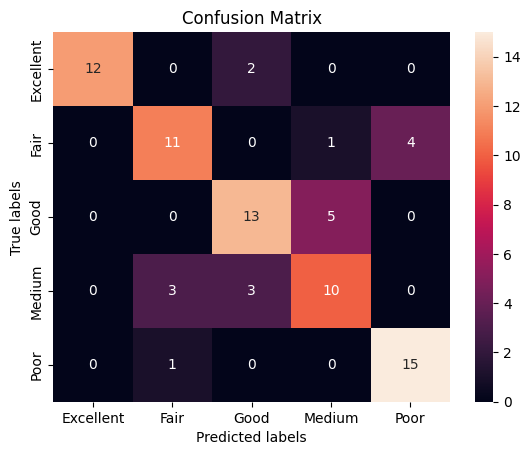

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(label_cls)
ax.yaxis.set_ticklabels(label_cls)

In [ ]:
# Classification report
print(classification_report(y_test, y_pred, target_names=label_cls))

              precision    recall  f1-score   support

   Excellent       1.00      0.86      0.92        14
        Fair       0.73      0.69      0.71        16
        Good       0.72      0.72      0.72        18
      Medium       0.62      0.62      0.62        16
        Poor       0.79      0.94      0.86        16

    accuracy                           0.76        80
   macro avg       0.77      0.77      0.77        80
weighted avg       0.77      0.76      0.76        80



# **Predictions**

In [ ]:
from tqdm import tqdm

df_final['predicted_wqc'] = ''

for idx, row in tqdm(df_final.iterrows(), total=df_final.shape[0]):
    features = row.drop(['wqc', 'Longitude', 'Latitude', 'predicted_wqc'])
    coordinates = row[['Longitude', 'Latitude']]
    features = scaler_feature.transform([features])
    coordinates = scaler_coordinate.transform([coordinates])
    features = [features, coordinates]
    prediction = model.predict(features, verbose=0)
    prediction = np.argmax(prediction, axis=1)
    label = label_cls[prediction[0]]
    df_final.at[idx, 'predicted_wqc'] = label

100%|██████████| 799/799 [01:27<00:00,  9.14it/s]


In [ ]:
df_coor = pd.read_excel(coordinate_file_path)
df_coor['Longitude'] = df_coor['Longitude and Latitude'].str.split(',').str[0]
df_coor['Latitude'] = df_coor['Longitude and Latitude'].str.split(',').str[1]

df_coor.drop('Longitude and Latitude', axis=1, inplace=True)
df_coor['Longitude'] = df_coor['Longitude'].astype('float')
df_coor['Latitude'] = df_coor['Latitude'].astype('float')

# Merge on Longitude and Latitude
df_final_coor = pd.merge(df_final, df_coor, on=['Longitude', 'Latitude'], how='inner')
df_final_coor['well_code'] = label_encoder_well_code.inverse_transform(df_final_coor['well_code'])
df_final_coor

,well_code,na,hco3,hardness_permanent,co2_free,sio2,wqc,Longitude,Latitude,predicted_wqc,No,Well Point Number,Project Number,Monitoring Object,Commune,District,Province,Station
0,B1,2501.00,149.50,32.5,8.8,0.40,Excellent,20.560557,106.568461,Excellent,6.0,B1,B1,Biển,TT.Diêm Điền,Thái Thụy,Thái Bình,Quynh Phu - Diem Dien Station
1,B1,1900.00,137.30,2395.0,11.0,0.32,Excellent,20.560557,106.568461,Excellent,6.0,B1,B1,Biển,TT.Diêm Điền,Thái Thụy,Thái Bình,Quynh Phu - Diem Dien Station
2,B1,22.15,88.48,160.0,6.6,0.32,Poor,20.560557,106.568461,Poor,6.0,B1,B1,Biển,TT.Diêm Điền,Thái Thụy,Thái Bình,Quynh Phu - Diem Dien Station
3,B1,86.00,164.75,330.0,11.0,0.60,Poor,20.560557,106.568461,Fair,6.0,B1,B1,Biển,TT.Diêm Điền,Thái Thụy,Thái Bình,Quynh Phu - Diem Dien Station
4,B1,695.80,109.84,945.0,2.2,0.00,Good,20.560557,106.568461,Good,6.0,B1,B1,Biển,TT.Diêm Điền,Thái Thụy,Thái Bình,Quynh Phu - Diem Dien Station
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,TB1,3.90,112.89,123.8,4.4,0.54,Poor,20.880442,106.401212,Poor,8.0,TB1,TB1,NM,Thanh Hải,Thanh Hà,Hải Dương,Tu Loc - Nam Thanh Station
1424,TB1,7.10,125.09,155.0,4.4,0.68,Poor,20.880442,106.401212,Poor,8.0,TB1,TB1,NM,Thanh Hải,Thanh Hà,Hải Dương,Tu Loc - Nam Thanh Station
1425,TB1,5.00,67.12,127.5,0.0,0.20,Poor,20.880442,106.401212,Poor,8.0,TB1,TB1,NM,Thanh Hải,Thanh Hà,Hải Dương,Tu Loc - Nam Thanh Station
1426,TB1,7.95,109.84,143.8,2.2,6.00,Poor,20.880442,106.401212,Poor,8.0,TB1,TB1,NM,Thanh Hải,Thanh Hà,Hải Dương,Tu Loc - Nam Thanh Station
